In [81]:
import os
import PIL
import shutil
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, LeakyReLU, ReLU, Input
from tensorflow.keras import Model, layers
from tensorflow.keras.layers import (
    Input, Conv2D, Conv2DTranspose, BatchNormalization,
    LeakyReLU, ReLU, Dropout, Add, Multiply, Attention
)
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.layers import SpectralNormalization
import matplotlib.pyplot as plt
import random

In [82]:
data_path = 'data/'

In [83]:
monet_filenames= tf.io.gfile.glob(str(data_path + '/monet_jpg/*.jpg'))
photo_filenames = tf.io.gfile.glob(str(data_path + '/photo_jpg/*.jpg'))

In [84]:
print(f'Number of Monet files: {len(monet_filenames)}')
print(f'Number of photograph files: {len(photo_filenames)}')

Number of Monet files: 300
Number of photograph files: 7038


Monet image shape: (256, 256, 3)
Photo image shape: (256, 256, 3)


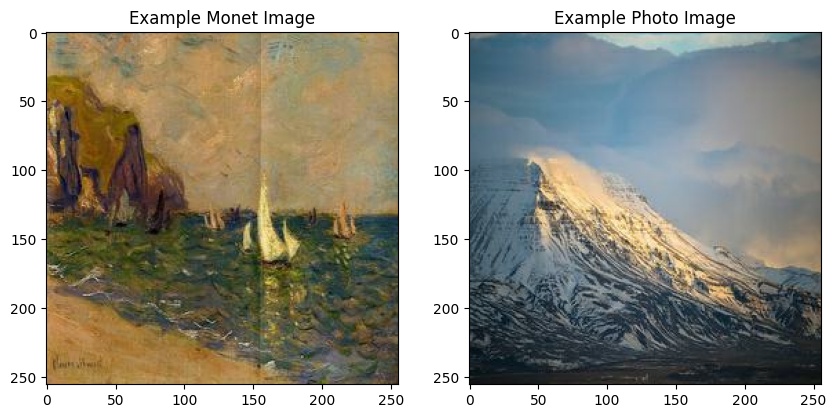

In [85]:
if monet_filenames and photo_filenames:
    example_monet_path = monet_filenames[random.randint(0, len(monet_filenames)) ]
    monet_image = tf.io.read_file(example_monet_path)
    monet_image = tf.image.decode_jpeg(monet_image, channels=3)
    print("Monet image shape:", monet_image.shape)

    example_photo_path = photo_filenames[random.randint(0, len(photo_filenames))]
    photo_image = tf.io.read_file(example_photo_path)
    photo_image = tf.image.decode_jpeg(photo_image, channels=3)
    print("Photo image shape:", photo_image.shape)
    
    # Display the images side by side
    plt.figure(figsize=(10, 5)) 

    # Show Monet image in the first subplot
    plt.subplot(1, 2, 2)
    plt.imshow(photo_image.numpy())
    plt.title("Example Photo Image")

    # Show Photo image in the second subplot
    plt.subplot(1, 2, 1)
    plt.imshow(monet_image.numpy())
    plt.title("Example Monet Image")

    plt.show()

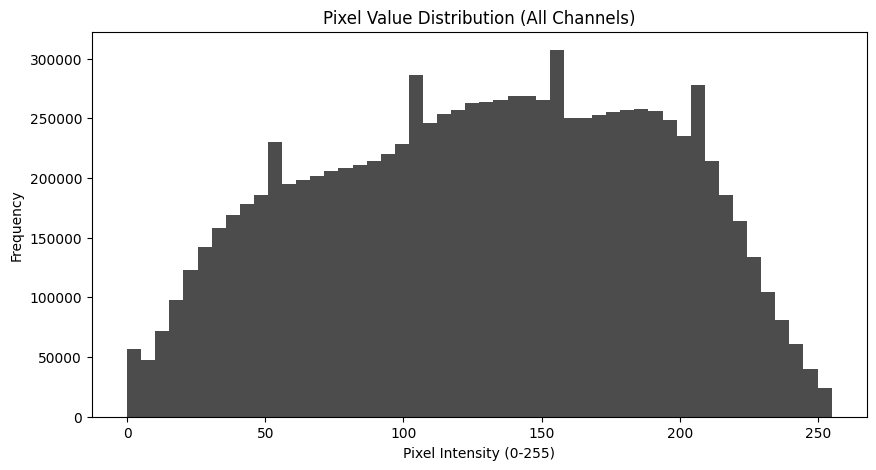

In [86]:
# Pixel value distribution

# Collect pixel values from a sample of images
sample_images = random.sample(monet_filenames, 50)
pixel_values = []

for filename in sample_images:
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)
    image = image.numpy().flatten()
    pixel_values.extend(image)

# Plot histogram
plt.figure(figsize=(10, 5))
plt.hist(pixel_values, bins=50, color='black', alpha=0.7)
plt.title('Pixel Value Distribution (All Channels)')
plt.xlabel('Pixel Intensity (0-255)')
plt.ylabel('Frequency')
plt.show()

In [87]:
# Initialize accumulators
total_pixels = 0
sum_rgb = np.zeros(3)
sum_sq_rgb = np.zeros(3)

for filename in monet_filenames:
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [256, 256]).numpy()
    
    sum_rgb += image.mean(axis=(0, 1))
    sum_sq_rgb += (image**2).mean(axis=(0, 1))
    total_pixels += 1

# Calculate final statistics
mean = sum_rgb / total_pixels
std = np.sqrt(sum_sq_rgb/total_pixels - mean**2)

print(f"Dataset Mean (RGB): {mean}")
print(f"Dataset Std (RGB): {std}")

Dataset Mean (RGB): [131.80562912 133.75694707 120.24496012]
Dataset Std (RGB): [57.85646349 56.16768997 62.97409039]


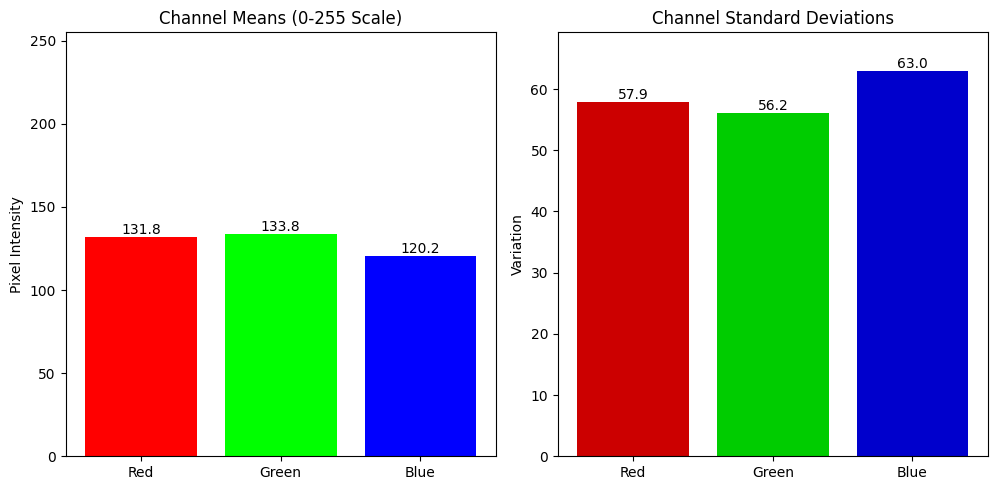

In [88]:
# Create figure with subplots
plt.figure(figsize=(15, 5))

# Plot 1: Channel means with color bars
plt.subplot(1, 3, 1)
bars = plt.bar(['Red', 'Green', 'Blue'], mean, 
               color=['#ff0000', '#00ff00', '#0000ff'])
plt.title('Channel Means (0-255 Scale)')
plt.ylabel('Pixel Intensity')
plt.ylim(0, 255)

# Add exact values on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}',
             ha='center', va='bottom')

# Plot 2: Channel standard deviations
plt.subplot(1, 3, 2)
bars = plt.bar(['Red', 'Green', 'Blue'], std,
               color=['#cc0000', '#00cc00', '#0000cc'])
plt.title('Channel Standard Deviations')
plt.ylabel('Variation')
plt.ylim(0, np.max(std) * 1.1)

# Add exact values on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [89]:
"""
Data Preprocessing Pipeline for Monet GAN

This module handles:
- Image loading and decoding
- Resizing and normalization
- Dataset shuffling/batching
- Performance optimization
"""

import tensorflow as tf
from typing import List

# Configuration Constants ------------------------------------------------------
IMG_HEIGHT = 256     # Target image height
IMG_WIDTH = 256      # Target image width
BUFFER_SIZE = 1000   # Shuffle buffer size (keep smaller than dataset size)
BATCH_SIZE = 16      # Training batch size
AUTOTUNE = tf.data.AUTOTUNE  # Allow runtime to optimize parallel processing

def preprocess_image(image_bytes: tf.Tensor) -> tf.Tensor:
    """
    Process raw image bytes into normalized tensors.
    
    Args:
        image_bytes: Tensor containing JPEG-encoded image data
        
    Returns:
        Normalized float32 tensor in range [-1, 1]
        
    Processing Steps:
        1. Decode JPEG with 3 color channels
        2. Convert to RGB color space
        3. Resize to target dimensions
        4. Normalize pixel values
    """
    try:
        # Decode with explicit RGB conversion for color consistency
        image = tf.image.decode_jpeg(image_bytes, channels=3)
        image = tf.image.convert_image_dtype(image, tf.float32)  # Handles scaling
        
        # Maintain aspect ratio with padding if needed (alternative approach)
        # image = tf.image.resize_with_pad(image, IMG_HEIGHT, IMG_WIDTH)
        
        # Resize with bilinear interpolation for better quality
        image = tf.image.resize(
            image, [IMG_HEIGHT, IMG_WIDTH],
            method=tf.image.ResizeMethod.BILINEAR
        )
        
        # Normalize to [-1, 1] range (standard for GANs with tanh activation)
        image = (image - 0.5) * 2.0
        
        # Ensure proper shape in case of corrupt images
        image.set_shape([IMG_HEIGHT, IMG_WIDTH, 3])
        
        return image
        
    except tf.errors.InvalidArgumentError as e:
        # Handle corrupt image files
        print(f"Error processing image: {e}")
        return tf.zeros([IMG_HEIGHT, IMG_WIDTH, 3])  # Return blank image

def load_dataset(filenames: List[str], 
                shuffle: bool = True) -> tf.data.Dataset:
    """
    Create optimized TensorFlow Dataset pipeline.
    
    Args:
        filenames: List of file paths
        shuffle: Whether to shuffle the dataset
        
    Returns:
        Batched and optimized TF Dataset
    """
    # Validate input
    if not filenames:
        raise ValueError("Empty file list provided to load_dataset")
    
    # Create base dataset
    dataset = tf.data.Dataset.from_tensor_slices(filenames)
    
    # Shuffle filenames before reading to improve I/O patterns
    if shuffle:
        dataset = dataset.shuffle(len(filenames), reshuffle_each_iteration=True)
    
    # Parallel file reading and preprocessing
    dataset = dataset.map(
        lambda x: tf.io.read_file(x),
        num_parallel_calls=AUTOTUNE
    )
    
    # Handle corrupt images by ignoring them
    dataset = dataset.map(
        preprocess_image,
        num_parallel_calls=AUTOTUNE
    ).apply(
        tf.data.experimental.ignore_errors()
    )
    
    # Performance optimizations
    dataset = dataset.cache()  # Cache after preprocessing
    if shuffle:
        dataset = dataset.shuffle(BUFFER_SIZE)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)
    
    return dataset

# Dataset Creation -------------------------------------------------------------
try:
    monet_ds = load_dataset(monet_filenames, shuffle=True)
    photo_ds = load_dataset(photo_filenames, shuffle=True)
    
    # Verify dataset creation
    if tf.data.experimental.cardinality(monet_ds) == 0:
        raise RuntimeError("Monet dataset is empty after preprocessing")
    if tf.data.experimental.cardinality(photo_ds) == 0:
        raise RuntimeError("Photo dataset is empty after preprocessing")
    
except (tf.errors.InvalidArgumentError, ValueError) as e:
    print(f"Dataset creation failed: {e}")
    raise

In [90]:
# diagnostic logging
print("\nDataset Summary:")
print(f"Monet examples: {len(monet_filenames)}")
print(f"Photo examples: {len(photo_filenames)}")
print(f"Monet batches: {tf.data.experimental.cardinality(monet_ds)}")
print(f"Photo batches: {tf.data.experimental.cardinality(photo_ds)}")
print(f"Output signature: {monet_ds.element_spec}\n")


Dataset Summary:
Monet examples: 300
Photo examples: 7038
Monet batches: -2
Photo batches: -2
Output signature: TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)



In [91]:
# Quick sanity check
# Verify the diagnostic output, Check for any corruption warnings, Ensure the pixel ranges are [-1, 1], Confirm batch shapes are (16, 256, 256, 3)
for batch in monet_ds.take(1):
    print("Monet batch shape:", batch.shape)
    print("Pixel range:", tf.reduce_min(batch).numpy(), 
          tf.reduce_max(batch).numpy())

for batch in photo_ds.take(1):
    print("Photo batch shape:", batch.shape)
    print("Pixel range:", tf.reduce_min(batch).numpy(),
          tf.reduce_max(batch).numpy())

Monet batch shape: (16, 256, 256, 3)
Pixel range: -1.0 1.0
Photo batch shape: (16, 256, 256, 3)
Pixel range: -1.0 1.0


In [99]:
"""
Generator with Keras-native Spectral Normalization
"""

class SelfAttention(layers.Layer):
    """Self-attention layer compatible with both symbolic and concrete tensors"""
    def __init__(self, filters):
        super().__init__()
        self.filters = filters
        
        # Initialize learnable gamma parameter
        self.gamma = self.add_weight(
            name='gamma',
            shape=(),
            initializer='zeros',
            trainable=True
        )
        
        # Create spectrally normalized convolutions
        self.query_conv = layers.Conv2D(filters//8, 1)
        self.key_conv = layers.Conv2D(filters//8, 1)
        self.value_conv = layers.Conv2D(filters, 1)

    def call(self, x):
        # Project inputs
        q = self.query_conv(x)  # [B, H, W, C//8]
        k = self.key_conv(x)    # [B, H, W, C//8]
        v = self.value_conv(x)  # [B, H, W, C]
        
        # Get shapes in a way that works with both symbolic and concrete tensors
        batch_size = tf.shape(x)[0]
        h = tf.shape(x)[1]
        w = tf.shape(x)[2]
        num_channels = self.filters // 8
        
        # Reshape for attention computation - use reshape with static shape info where possible
        q_flat = tf.reshape(q, [batch_size, h * w, num_channels])
        k_flat = tf.reshape(k, [batch_size, h * w, num_channels])
        v_flat = tf.reshape(v, [batch_size, h * w, self.filters])
        
        # Compute attention scores
        attn_logits = tf.matmul(q_flat, k_flat, transpose_b=True)
        attn_weights = tf.nn.softmax(attn_logits, axis=-1)
        
        # Apply attention to values
        out = tf.matmul(attn_weights, v_flat)
        
        # Reshape back to spatial dimensions
        out = tf.reshape(out, [batch_size, h, w, self.filters])
        
        # Add residual connection
        return self.gamma * out + x

    
def residual_block(x, filters, use_sn=True):
    """Residual block with optional spectral normalization"""
    shortcut = x
    
    # First convolution
    conv1 = layers.Conv2D(filters, 3, padding='same')
    if use_sn:
        conv1 = layers.SpectralNormalization(conv1)
    x = conv1(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    # Second convolution
    conv2 = layers.Conv2D(filters, 3, padding='same')
    if use_sn:
        conv2 = layers.SpectralNormalization(conv2)
    x = conv2(x)
    x = layers.BatchNormalization()(x)
    
    return layers.Add()([shortcut, x])

def build_generator():
    inputs = layers.Input(shape=(256, 256, 3))
    
    # Downsampling path
    conv1 = layers.Conv2D(64, 4, strides=2, padding='same')
    d1 = layers.SpectralNormalization(conv1)(inputs)
    d1 = layers.LeakyReLU(0.2)(d1)
    
    conv2 = layers.Conv2D(128, 4, strides=2, padding='same')
    d2 = layers.SpectralNormalization(conv2)(d1)
    d2 = layers.BatchNormalization()(d2)
    d2 = layers.LeakyReLU(0.2)(d2)
    
    # Bottleneck with self-attention
    conv3 = layers.Conv2D(256, 4, strides=2, padding='same')
    d3 = layers.SpectralNormalization(conv3)(d2)
    d3 = layers.BatchNormalization()(d3)
    d3 = layers.LeakyReLU(0.2)(d3)
    
    # Add residual blocks and attention
    rb = residual_block(d3, 256)
    rb = SelfAttention(256)(rb)
    
    # Upsampling path
    u1 = layers.Conv2DTranspose(128, 4, strides=2, padding='same')(rb)
    u1 = layers.BatchNormalization()(u1)
    u1 = layers.ReLU()(u1)
    u1 = layers.Add()([u1, d2])
    
    u2 = layers.Conv2DTranspose(64, 4, strides=2, padding='same')(u1)
    u2 = layers.BatchNormalization()(u2)
    u2 = layers.ReLU()(u2)
    u2 = layers.Add()([u2, d1])
    
    output = layers.Conv2DTranspose(3, 4, strides=2, padding='same', activation='tanh')(u2)
    
    return Model(inputs=inputs, outputs=output)

def test_generator():
    # Build generator with fixed attention
    generator = build_generator()
    
    # Test symbolic shape inference
    symbolic_input = tf.keras.Input(shape=(256, 256, 3))
    symbolic_output = generator(symbolic_input)
    assert symbolic_output.shape == (None, 256, 256, 3), \
        f"Symbolic shape mismatch: {symbolic_output.shape}"
    
    # Test concrete execution
    concrete_input = tf.random.normal([1, 256, 256, 3])
    concrete_output = generator(concrete_input)
    assert concrete_output.shape == (1, 256, 256, 3), \
        f"Concrete shape mismatch: {concrete_output.shape}"
    
    print("Generator test passed!")

test_generator()

Generator test passed!


In [102]:
"""
Enhanced PatchGAN Discriminator with Spectral Norm and Attention
"""

class DiscriminatorResBlock(layers.Layer):
    """Residual block for discriminator with downsampling"""
    def __init__(self, filters, use_sn=True, downsample=True):
        super().__init__()
        self.filters = filters
        self.downsample = downsample
        
        # First convolution
        self.conv1 = layers.Conv2D(filters, 3, strides=1, padding='same')
        if use_sn:
            self.conv1 = layers.SpectralNormalization(self.conv1)
        self.act1 = layers.LeakyReLU(0.2)
        
        # Second convolution
        self.conv2 = layers.Conv2D(filters, 3, strides=1, padding='same')
        if use_sn:
            self.conv2 = layers.SpectralNormalization(self.conv2)
        self.act2 = layers.LeakyReLU(0.2)
        
        # Residual connection with projection if needed
        self.project = None
        if downsample:
            # Separate downsampling and residual projection
            self.downsample_layer = layers.AveragePooling2D(pool_size=2)
            
            # Projection for residual if input channels don't match output
            self.project = layers.Conv2D(filters, 1, strides=1, padding='same')
            if use_sn:
                self.project = layers.SpectralNormalization(self.project)
    
    def build(self, input_shape):
        # Check if we need to create a projection for the residual
        input_channels = input_shape[-1]
        if input_channels != self.filters and self.project is None:
            self.project = layers.Conv2D(self.filters, 1, strides=1, padding='same')
        super().build(input_shape)
    
    def call(self, x):
        # Save residual
        residual = x
        
        # First conv block
        x = self.conv1(x)
        x = self.act1(x)
        
        # Second conv block
        x = self.conv2(x)
        x = self.act2(x)
        
        # Apply downsampling if needed
        if self.downsample:
            x = self.downsample_layer(x)
        
        # Project residual if needed
        if self.project is not None:
            residual = self.project(residual)
            # Downsample residual if needed
            if self.downsample:
                residual = self.downsample_layer(residual)
        
        # Add residual connection
        return x + residual

def build_discriminator(img_size=256, use_sn=True):
    """
    Enhanced PatchGAN discriminator with:
    - Spectral normalization
    - Residual blocks
    - Self-attention
    """
    init = RandomNormal(stddev=0.02)
    inputs = layers.Input(shape=(img_size, img_size, 3))
    
    # Initial convolution block
    x = layers.Conv2D(64, 4, strides=2, padding='same', kernel_initializer=init)(inputs)
    x = layers.LeakyReLU(0.2)(x)
    
    # Residual blocks with downsampling
    x = DiscriminatorResBlock(128, use_sn=use_sn, downsample=True)(x)  # 64x64
    x = DiscriminatorResBlock(256, use_sn=use_sn, downsample=True)(x)  # 32x32
    x = DiscriminatorResBlock(512, use_sn=use_sn, downsample=True)(x)  # 16x16
    
    # Self-attention layer
    x = SelfAttention(512)(x)
    
    # Final layers
    x = layers.Conv2D(512, 4, strides=1, padding='same', kernel_initializer=init)(x)
    x = layers.LeakyReLU(0.2)(x)
    
    # Output: PatchGAN
    x = layers.Conv2D(1, 4, padding='same', kernel_initializer=init)(x)
    
    # Average pooling across spatial dimensions
    x = layers.GlobalAveragePooling2D()(x)
    
    return Model(inputs=inputs, outputs=x, name="Discriminator")

# Verification test
def test_discriminator():
    discriminator = build_discriminator()
    
    # Test symbolic input
    symbolic_input = tf.keras.Input(shape=(256, 256, 3))
    symbolic_output = discriminator(symbolic_input)
    assert symbolic_output.shape == (None, 1), "Symbolic shape mismatch!"
    
    # Test concrete input
    concrete_input = tf.random.normal([1, 256, 256, 3])
    concrete_output = discriminator(concrete_input)
    assert concrete_output.shape == (1, 1), "Concrete shape mismatch!"
    
    print("Discriminator test passed!")

test_discriminator()

Discriminator test passed!


In [ ]:
# Enhanced WGAN-GP Loss Functions with:
#- Dynamic batch size handling
#- Gradient norm stabilization
#- Diagnostic metrics
#- Numerical stability checks

class WGANGPLoss:
    def __init__(self, lambda_gp=10, epsilon=1e-8):
        self.lambda_gp = lambda_gp
        self.epsilon = epsilon
        
    def discriminator_loss(self, real_scores, fake_scores):
        """
        Wasserstein discriminator loss
        Args:
            real_scores: Output from real images (shape: [batch_size, 1])
            fake_scores: Output from generated images (shape: [batch_size, 1])
        """
        # Validate inputs
        tf.debugging.assert_shapes([
            (real_scores, ('B', 1)),
            (fake_scores, ('B', 1))
        ])
        
        real_loss = tf.reduce_mean(real_scores)
        fake_loss = tf.reduce_mean(fake_scores)
        
        # Add metrics for monitoring
        tf.summary.scalar('d_real_scores', real_loss)
        tf.summary.scalar('d_fake_scores', fake_loss)
        tf.summary.histogram('real_scores_dist', real_scores)
        tf.summary.histogram('fake_scores_dist', fake_scores)
        
        return fake_loss - real_loss

    def generator_loss(self, fake_scores):
        """Wasserstein generator loss"""
        # Add metrics for monitoring
        tf.summary.scalar('g_fake_scores', tf.reduce_mean(fake_scores))
        return -tf.reduce_mean(fake_scores)

    def gradient_penalty(self, real_images, fake_images, discriminator):
        """Calculated gradient penalty with dynamic batch handling"""
        # Dynamic batch size
        batch_size = tf.shape(real_images)[0]
        
        # Validate inputs
        tf.debugging.assert_shapes([
            (real_images, ('B', 'H', 'W', 'C')),
            (fake_images, ('B', 'H', 'W', 'C'))
        ])
        
        # Generate random interpolation coefficients
        alpha = tf.random.uniform(
            shape=[batch_size] + [1]*(real_images.shape.rank - 1),
            minval=0.0,
            maxval=1.0
        )
        
        # Create interpolated images
        interpolated = alpha * real_images + (1 - alpha) * fake_images
        
        # Calculate gradients
        with tf.GradientTape(watch_accessed_variables=False) as tape:
            tape.watch(interpolated)
            pred = discriminator(interpolated)
        
        gradients = tape.gradient(pred, interpolated)
        
        # Calculate gradient norms
        gradients_sqr = tf.square(gradients + self.epsilon)
        gradients_norm = tf.sqrt(
            tf.reduce_sum(gradients_sqr, axis=[1, 2, 3]))
        
        # Calculate penalty and add metrics
        gradient_penalty = tf.reduce_mean((gradients_norm - 1.0) ** 2)
        tf.summary.scalar('gradient_penalty', gradient_penalty)
        tf.summary.histogram('gradient_norms', gradients_norm)
        
        return self.lambda_gp * gradient_penalty

    def drift_penalty(self, real_scores):
        """Additional penalty to prevent score drift"""
        return 0.001 * tf.reduce_mean(tf.square(real_scores))

# Usage
LOSS = WGANGPLoss(lambda_gp=10)

In [105]:
# Loss verification test
def test_losses():
    # Initialize components
    loss = WGANGPLoss()
    discriminator = build_discriminator()
    batch_size = 4
    
    # Test data
    real = tf.random.normal([batch_size, 256, 256, 3])
    fake = tf.random.normal([batch_size, 256, 256, 3])
    
    # Test discriminator loss
    real_scores = discriminator(real)
    fake_scores = discriminator(fake)
    d_loss = loss.discriminator_loss(real_scores, fake_scores)
    assert d_loss.shape == ()
    
    # Test gradient penalty
    gp = loss.gradient_penalty(real, fake, discriminator)
    assert gp.shape == ()
    
    # Test generator loss
    g_loss = loss.generator_loss(fake_scores)
    assert g_loss.shape == ()
    
    print("All loss tests passed!")

test_losses()

All loss tests passed!


In [ ]:
# Training Loop w/ Checkpoints

generator = build_generator()
discriminator = build_discriminator()

g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
d_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

@tf.function
def train_step(real_monet, real_photo):
    # Discriminator training
    with tf.GradientTape() as d_tape:
        generated_images = generator(real_photo, training=True)
        real_output = discriminator(real_monet, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        d_loss = discriminator_loss(real_output, fake_output)
        gp = gradient_penalty(real_monet, generated_images, discriminator)
        total_d_loss = d_loss + gp
    
    d_gradients = d_tape.gradient(total_d_loss, discriminator.trainable_variables)
    d_optimizer.apply_gradients(zip(d_gradients, discriminator.trainable_variables))
    
    # Generator training
    with tf.GradientTape() as g_tape:
        generated_images = generator(real_photo, training=True)
        fake_output = discriminator(generated_images, training=True)
        g_loss = generator_loss(fake_output)
    
    g_gradients = g_tape.gradient(g_loss, generator.trainable_variables)
    g_optimizer.apply_gradients(zip(g_gradients, generator.trainable_variables))
    
    return {'d_loss': total_d_loss, 'g_loss': g_loss}

# Training loop
for epoch in range(EPOCHS):
    for photo_batch, monet_batch in tf.data.Dataset.zip((photo_ds, monet_ds)):
        losses = train_step(monet_batch, photo_batch)
    
    # Save checkpoints periodically
    if (epoch + 1) % 10 == 0:
        generator.save(f'generator_epoch_{epoch+1}.h5')
        discriminator.save(f'discriminator_epoch_{epoch+1}.h5')
    
    print(f"Epoch {epoch+1}: D_loss={losses['d_loss']:.3f}, G_loss={losses['g_loss']:.3f}")

In [ ]:
# Image generation and submission

def generate_and_save_images(model, test_input, output_dir='images'):
    os.makedirs(output_dir, exist_ok=True)
    predictions = model(test_input, training=False)
    for i in range(predictions.shape[0]):
        img = (predictions[i].numpy() * 127.5 + 127.5).astype(np.uint8)
        PIL.Image.fromarray(img).save(f'{output_dir}/image_{i:05d}.jpg')

# Generate 10,000 images
num_images = 10000
test_seed = tf.random.normal([num_images, 256, 256, 3])
generate_and_save_images(generator, test_seed)

# Create zip file
shutil.make_archive('images', 'zip', 'images')